In [1]:
from pyspark.sql import SparkSession, functions as F, Row
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.functions import vector_to_array
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import roc_auc_score
import math
import numpy as np

In [2]:
spark = SparkSession.builder.appName("Dimension Reduction").master("local[*]").getOrCreate()


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/07/12 22:44:40 WARN Utils: Your hostname, Soroush, resolves to a loopback address: 127.0.1.1; using 192.168.100.10 instead (on interface wlp5s0)
25/07/12 22:44:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/12 22:44:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Import Musk version 2 dataset

In [3]:
df = (
    spark
      .read
      .option("header", True)
      .option("inferSchema", True)
      .csv("glass_identification.csv")
      .withColumn("id", F.monotonically_increasing_id())
      .withColumnRenamed("target", "class")
      .cache()
)

# df = df.dropDuplicates()

label_col    = "class"
feature_cols = [c for c in df.columns if c not in ("id", label_col)]

labels = (
    df
      .select("id", (1 - F.col("class")).alias("label").cast("int"))
      .cache()
)


In [4]:
total = df.count()
distinct = df.dropDuplicates(feature_cols).count()
duplicates = total - distinct
print(f"Found {duplicates} duplicate rows out of {total}")

Found 1 duplicate rows out of 214


 #### Parameters
##### K: LOF Neighbors
##### P: Bins Per Feature
##### M: Subspace Size

In [5]:
params = {
    'p': 2,
    'm': 3,
    'k': 74
}


#### Scale With Max_Min Normalization method

In [6]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")
assembled_df = assembler.transform(df)

scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
df_scaled = scaler.fit(assembled_df).transform(assembled_df).select("id", "scaledFeatures")


### Density Based Representation

In [7]:
num_feats = len(feature_cols)
p = params['p']
cube_counts = (
    df_scaled.select("scaledFeatures").rdd
    .map(lambda row: tuple(int(min(x * p, p - 1)) for x in row.scaledFeatures))
    .map(lambda bins: ("_".join(map(str, bins)), 1))
    .reduceByKey(lambda a, b: a + b)
)

density_df = spark.createDataFrame(
    cube_counts.map(lambda kv: Row(cube_id=kv[0], density=kv[1]))
)

for i in range(num_feats):
    density_df = density_df.withColumn(f"g{i}", F.split("cube_id", "_")[i].cast("int"))


#### mRMRD-Based Relevant Subspace Selection

In [8]:
# RDD format
col_names = [f"g{i}" for i in range(num_feats)]
mr_rdd    = density_df.select(col_names + ["density"]).rdd.cache()
N_total   = mr_rdd.count()

# calculate similarity
fd_counts = (
    mr_rdd.flatMap(
        lambda row: [((j, getattr(row, col_names[j]), row.density), 1) for j in range(num_feats)]
    ).reduceByKey(lambda a, b: a + b)
)

feat_marg = fd_counts.map(lambda kv: ((kv[0][0], kv[0][1]), kv[1])).reduceByKey(lambda a, b: a + b)

dens_marg = fd_counts.map(lambda kv: (kv[0][2], kv[1])).reduceByKey(lambda a, b: a + b)

fd_list      = fd_counts.collect()
feat_dict    = dict(feat_marg.collect())
dens_dict    = dict(dens_marg.collect())

mi_relevance = {}
for (j, gval, dc), cnt in fd_list:
    p_joint = cnt / N_total
    p_g     = feat_dict[(j, gval)] / N_total
    p_d     = dens_dict[dc] / N_total
    mi_relevance[j] = mi_relevance.get(j, 0.0) + p_joint * math.log2(p_joint / (p_g * p_d))


#### Compute I(gi,gj) And Redundancy

In [9]:
pair_counts = (
    mr_rdd.flatMap(
        lambda row: [(((j, l, getattr(row, col_names[j]), getattr(row, col_names[l]))), 1)
                      for j in range(num_feats) for l in range(j + 1, num_feats)]
    ).reduceByKey(lambda a, b: a + b)
)

# aggregate pair dictionaries ( (j , l) , ( (v1,v2),cnt))
from collections import defaultdict
pair_dict = defaultdict(list)
for ((j, l, vj, vl), c) in pair_counts.collect():
    pair_dict[(j, l)].append(((vj, vl), c))

# compute mutual information
mi_pair = {}
for (j, l), items in pair_dict.items():
    score = 0.0
    for (vj, vl), cnt in items:
        p_joint = cnt / N_total
        p_j     = feat_dict[(j, vj)] / N_total
        p_l     = feat_dict[(l, vl)] / N_total
        score  += p_joint * math.log2(p_joint / (p_j * p_l))
    mi_pair[(j, l)] = score
    mi_pair[(l, j)] = score

#### Greedy mRMD Selection

In [10]:
subspace_size = params['m']
selected, remaining = [], list(range(num_feats))

while remaining and len(selected) < subspace_size:
    best, best_score = None, float("-inf")
    for cand in remaining:
        redund = 0.0
        if selected:
            redund = sum(mi_pair.get((cand, s), 0.0) for s in selected) / len(selected)
        score = mi_relevance[cand] - redund
        if score > best_score:
            best, best_score = cand, score
    selected.append(best)
    remaining.remove(best)

# see the selected features
print("\nSelected features (MRMD order):", [f"g{i}" for i in selected])


Selected features (MRMD order): ['g8', 'g2', 'g3']


#### Stage 5: Data Mapping

In [11]:
indexes = [int(col) for col in selected]  # from mRMRD
df_subspace = (
    df_scaled.withColumn("feat_arr", vector_to_array("scaledFeatures"))
    .select("id", *[F.col("feat_arr")[i].alias(f"f{j}") for j,i in enumerate(indexes)])
    .cache()
)

df_subspace.show(5, truncate=False)


+---+---+------------------+-------------------+
|id |f0 |f1                |f2                 |
+---+---+------------------+-------------------+
|0  |0.0|1.0               |0.2523364485981308 |
|1  |0.0|0.8017817371937639|0.3333333333333333 |
|2  |0.0|0.7906458797327394|0.3894080996884735 |
|3  |0.0|0.821826280623608 |0.3115264797507788 |
|4  |0.0|0.8062360801781737|0.29595015576323985|
+---+---+------------------+-------------------+
only showing top 5 rows


#### Stage 6: Compute LOF Scores
#### Remove Duplicates From Selected Subspace By MrMRD

In [12]:
total = df_subspace.count()
# list of subspace feature
subspace_cols = [f"f{i}" for i in range(len(indexes))]
# distinct rows by feature‐only
df_subspace = df_subspace.dropDuplicates(subspace_cols).cache()

df_subspace.show(5, truncate=False)


Found 5 exact‐duplicate rows out of 214 in the subspace.
After deduplication: 209 rows (should be 209).
+---+---+------------------+-------------------+
|id |f0 |f1                |f2                 |
+---+---+------------------+-------------------+
|23 |0.0|0.7951002227171491|0.3302180685358255 |
|28 |0.0|0.7839643652561247|0.3551401869158878 |
|104|0.0|0.6458797327394209|0.27414330218068533|
|17 |0.0|0.8574610244988864|0.1869158878504673 |
|103|0.0|0.7015590200445434|0.11526479750778817|
+---+---+------------------+-------------------+
only showing top 5 rows


#### Compute LOF With Sklearn Built-In Function

In [13]:

pdf = df_subspace.toPandas().set_index("id")
X   = pdf.values

# fit LOF in the projected space
lof = LocalOutlierFactor(n_neighbors=params['k'], metric="euclidean")
lof.fit_predict(X)

# invert sign so that higher => more anomalous
pdf["lof_score"] = -lof.negative_outlier_factor_


#### Merge LOF Scores with Scaled Features and Display Top Outliers

In [14]:
lof_df = spark.createDataFrame(
    pdf.reset_index()[["id", "lof_score"]]
)

df_final = (
    df_scaled
      .join(lof_df, on="id", how="inner")
      .orderBy(F.desc("lof_score"))
)

df_final.select("id", "lof_score").show(10, truncate=False)

+---+------------------+
|id |lof_score         |
+---+------------------+
|163|3.289920122765579 |
|174|2.3820864245797124|
|162|2.2630495700614532|
|145|2.235402539370376 |
|166|2.225221638935357 |
|180|2.220295411418472 |
|184|2.212903409397164 |
|164|2.19392878269361  |
|189|2.1928834294436137|
|190|2.191308231801513 |
+---+------------------+
only showing top 10 rows


#### Compute ROC‐AUC From df_final

In [15]:

# Identify the minority class
minority_class = df.groupBy("class").count().orderBy("count").first()["class"]
print(f"Minority class (outlier) = {minority_class}")

#Bring the original class labels
labels_df = df.select("id", "class")
#Join labels onto df_final
df_eval = df_final.join(labels_df, on="id", how="inner")
eval_pdf = df_eval.select("id", "lof_score", "class").toPandas()
#Build binary target and compute AUC
eval_pdf["binary_label"] = (eval_pdf["class"] == minority_class).astype(int)
auc = roc_auc_score(eval_pdf["binary_label"], eval_pdf["lof_score"])
print(f"✅ Final ROC‐AUC (class {minority_class} vs rest): {auc:.4f}")


Minority class (outlier) = 6
✅ Final ROC‐AUC (class 6 vs rest): 0.8041


#### Evaluate “Pure” LOF and Compare ROC Curves

Pure LOF AUC: 0.7168


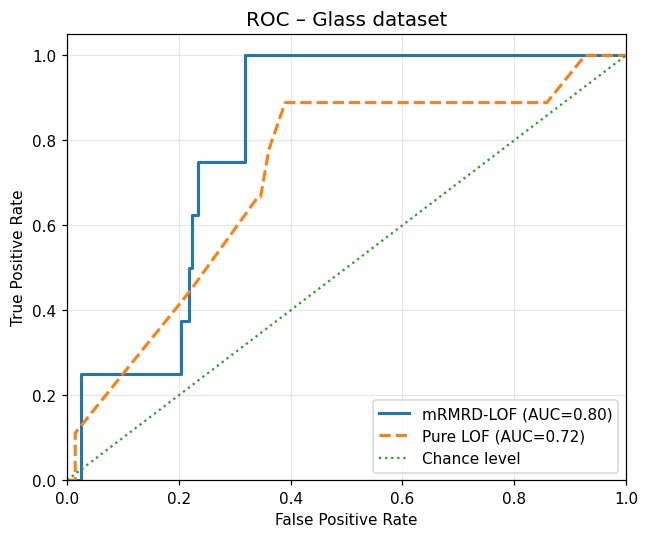

In [16]:
feature_cols = [c for c in df.columns if c not in ("id", "class")]
vec = VectorAssembler(inputCols=feature_cols, outputCol="vec")
df_vec = vec.transform(df)
scaler = MinMaxScaler(inputCol="vec", outputCol="scaled")
df_scaled = scaler.fit(df_vec).transform(df_vec)

pdf_pure = df_scaled.select("id", "scaled", "class").toPandas()
X_pure = np.vstack(pdf_pure["scaled"].values)
y_pure = (pdf_pure["class"] == minority_class).astype(int).values

# Pure LOF
lof_pure = LocalOutlierFactor(n_neighbors=212, novelty=True)
lof_pure.fit(X_pure)
pdf_pure["lof_score_pure"] = -lof_pure.decision_function(X_pure)
auc_pure = roc_auc_score(y_pure, pdf_pure["lof_score_pure"])
print(f"Pure LOF AUC: {auc_pure:.4f}")

#ROC curves – mRMRD vs Pure LOF

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt


fpr_m, tpr_m, _ = roc_curve(eval_pdf["binary_label"], eval_pdf["lof_score"])
fpr_p, tpr_p, _ = roc_curve(y_pure, pdf_pure["lof_score_pure"])

plt.figure(dpi=110, figsize=(6,5))
plt.plot(fpr_m, tpr_m, label=f"mRMRD‑LOF (AUC={auc:.2f})", linewidth=2)
plt.plot(fpr_p, tpr_p, "--", label=f"Pure LOF (AUC={auc_pure:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], ":", label="Chance level")
plt.xlim(0, 1); plt.ylim(0, 1.05)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC – Glass dataset", fontsize=13)
plt.grid(alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [1]:
from pipeline_components import run_pipeline_from_csv,compute_pipeline_auc


#### Test Run Time With Fiffernet Number Of Workers

In [1]:
import time
import pandas as pd
from pyspark.sql import SparkSession
from pipeline_components import run_pipeline_from_csv, compute_pipeline_auc

worker_counts = [1, 2, 4, 8]
timings = []

for workers in worker_counts:
    try:
        spark.stop()
    except:
        pass

    spark = SparkSession.builder \
        .master(f"local[{workers}]") \
        .appName(f"MyPipeline_{workers}workers") \
        .getOrCreate()

    print(f"Running pipeline with {workers} worker(s)...")
    start_time = time.time()

    # run and materialize
    lof_df, selected, cleaned_df = run_pipeline_from_csv(
        spark,
        "glass_identification.csv",
        p=2, m=3, k=74
    )
    lof_df.count()

    # correctly group by the 'target' column
    class_counts = (
        cleaned_df
        .groupBy("target")
        .count()
        .orderBy("count")
        .collect()
    )
    minority_class = class_counts[0]["target"]

    # compute AUC
    pipe_auc, pure_auc = compute_pipeline_auc(
    spark, "glass_identification.csv", minority_class, p=2, m=3, k=74)
    print(f"Pipeline LOF AUC: {pipe_auc:.4f}")
    print(f"Pure LOF AUC: {pure_auc:.4f}")

    elapsed = time.time() - start_time
    timings.append({"workers": workers, "duration_s": elapsed})
    print(f"→ Completed in {elapsed:.2f}s\n")

    spark.stop()

# summary
timing_df = pd.DataFrame(timings)
print("Pipeline timing by number of workers:")
print(timing_df)


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/07/13 01:53:05 WARN Utils: Your hostname, Soroush, resolves to a loopback address: 127.0.1.1; using 192.168.100.10 instead (on interface wlp5s0)
25/07/13 01:53:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/13 01:53:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Running pipeline with 1 worker(s)...


25/07/13 01:57:02 WARN CacheManager: Asked to cache already cached data.        
25/07/13 01:57:04 WARN CacheManager: Asked to cache already cached data.        


Pipeline LOF AUC: 0.8581
Pure LOF AUC: 0.7576
→ Completed in 468.56s

Running pipeline with 2 worker(s)...


25/07/13 02:03:01 WARN CacheManager: Asked to cache already cached data.        
25/07/13 02:03:02 WARN CacheManager: Asked to cache already cached data.


Pipeline LOF AUC: 0.8581
Pure LOF AUC: 0.7576
→ Completed in 245.16s

Running pipeline with 4 worker(s)...


25/07/13 02:06:09 WARN CacheManager: Asked to cache already cached data.        
25/07/13 02:06:10 WARN CacheManager: Asked to cache already cached data.


Pipeline LOF AUC: 0.8581
Pure LOF AUC: 0.7576
→ Completed in 132.41s

Running pipeline with 8 worker(s)...


25/07/13 02:07:54 WARN CacheManager: Asked to cache already cached data.        
25/07/13 02:07:55 WARN CacheManager: Asked to cache already cached data.


Pipeline LOF AUC: 0.8581
Pure LOF AUC: 0.7576
→ Completed in 76.43s

Pipeline timing by number of workers:
   workers  duration_s
0        1  468.560698
1        2  245.159066
2        4  132.410195
3        8   76.429736


#### Test With Different Number Of Workers

Spark version: 4.0.0


AUC (high score ⇒ anomaly): 0.4080
AUC (low  score ⇒ anomaly): 0.5920
